In [1]:
import glob
dirnames = glob.glob("r_*")
r = [int(d.split('_')[1]) for d in dirnames]

In [2]:
import sklearn
import tensorly as tl
from sklearn import decomposition, neighbors
def get_pca_testerr(X_train, X_test, r, target, train_idx, test_idx):
    corr = lambda x, y: 1 - np.dot(x/np.linalg.norm(x), y/np.linalg.norm(y))
    pca = sklearn.decomposition.PCA(n_components = r, svd_solver = 'full')
    X_train_pca = pca.fit_transform(tl.unfold(X_train, 0))
    X_test_pca = pca.transform(tl.unfold(X_test, 0))
    clf_pca = neighbors.KNeighborsClassifier(n_neighbors = 1, metric = corr)
    clf_pca.fit(X_train_pca, target[train_idx])
    # err_train = (clf_pca.predict(X_train_pca) != target[train_idx]).mean() # train error
    err_test = (clf_pca.predict(X_test_pca) != target[test_idx]).mean() # test error
    return err_test

In [3]:
import numpy as np
err_ot_all = []
err_cp_all = []
err_pca_all = []
for d in dirnames:
    outfiles = glob.glob(d + "/*.npz")
    err_ot = []
    err_cp = []
    err_pca = []
    for f in outfiles:
        out = np.load(f, allow_pickle = True)
        s = out['classif']
        err_ot += [1-out['classif'].item()['ot']['err_test'], ]
        err_cp += [1-out['classif'].item()['cp']['err_test'], ]
        err_pca += [1-out['classif'].item()['pca']['err_test'], ] 
        # recompute PCA.
        # err_pca += [1-get_pca_testerr(out['X_train'], out['X_test'], out['A'][0].shape[-1], out['target'], out['train_idx'], out['test_idx'])]
        
    err_ot_all += [err_ot, ]
    err_cp_all += [err_cp, ]
    err_pca_all += [err_pca, ]

In [4]:
import matplotlib.pyplot as plt
err_ot_all = [err_ot_all[i] for i in np.argsort(r)]
err_cp_all = [err_cp_all[i] for i in np.argsort(r)]
err_pca_all = [err_pca_all[i] for i in np.argsort(r)]
r = np.sort(r)

In [5]:
def set_violin_color(v, c, alpha = None):
    for k in v.keys():
        if k == "bodies":
            for pc in v[k]:
                pc.set_facecolor(c)
                pc.set_edgecolor(c)
                if alpha is not None:
                    pc.set_alpha(alpha)
        else:
            pc = v[k]
            pc.set_edgecolor(c)
            if alpha is not None:
                pc.set_alpha(alpha)
    return

Text(0.5, 0, 'basis components')

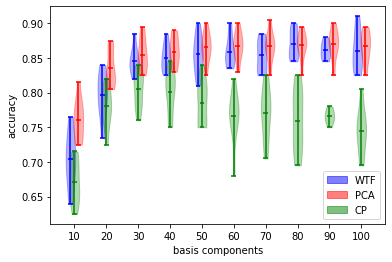

In [11]:
viol = plt.violinplot(err_ot_all, showmeans = True, positions = np.arange(len(r)) - 0.125, widths = 0.3);
set_violin_color(viol, 'blue')
viol = plt.violinplot(err_cp_all, showmeans = True, positions = np.arange(len(r)), widths = 0.3);
set_violin_color(viol, 'green')
viol = plt.violinplot(err_pca_all, showmeans = True, positions = np.arange(len(r)) + 0.125, widths = 0.3);
set_violin_color(viol, 'red')
plt.xticks(np.arange(len(r)), r);
leg = plt.legend(['WTF', 'PCA', 'CP'], loc = 'lower right')
leg.legendHandles[0].set_color("blue")
leg.legendHandles[0].set_alpha(0.5)
leg.legendHandles[1].set_color("red")
leg.legendHandles[1].set_alpha(0.5)
leg.legendHandles[2].set_color("green")
leg.legendHandles[2].set_alpha(0.5)
plt.ylabel("accuracy")
plt.xlabel("basis components")

Text(0.5, 0, 'basis components')

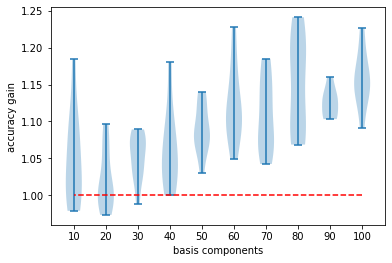

In [13]:
ratio_ot_cp = [np.array(err_ot_all[i])/np.array(err_cp_all[i])  for i in range(len(err_ot_all))]
plt.violinplot(ratio_ot_cp);
plt.hlines(1, len(ratio_ot_cp), 1, color = 'red', linestyle = 'dashed')
plt.xticks(np.arange(len(r))+1, r);
plt.ylabel("accuracy gain")
plt.xlabel("basis components")